## Import e funzioni utili

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.7.0

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 665.5 MB 69.6 MB/s
     |████████████████████████████████| 463 kB 8.5 MB/s 
     |████████████████████████████████| 1.3 MB 47.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import load_model

local = False

LOCAL_URL = "dropoutData/"
CLOUD_URL = "/content/drive/My Drive/dataset/Dropout/"

base_url = ""

if(local):
  base_url = LOCAL_URL
else:
  base_url = CLOUD_URL


def print_missing_values(dt):
  pd.options.mode.use_inf_as_na = True
  for col in dt.columns:
    na = int(dt[col].isna().sum())
    print("Column '" + col + "' has " + str(na) + " missing values")

def print_columns_len(dt):
  for col in dt.columns:
    print("column '" + col + "' has " + str(len(dt[col])) + " values")

def save_model(model, filename):
  joblib.dump(model, base_url + filename)

def load_model(filename):
  return joblib.load(base_url + filename)

def print_classification_report_n_mconfusion(y_pred, y_true):
  print(classification_report(y_pred, y_true))
  cm = confusion_matrix(y_test, y_pred) 
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

def SquareErrorDataPoints(_input, _output):
    #input = np.squeeze(_input, axis=0)
    #output = np.squeeze(_output, axis=0)
    # Caculate error
    error = np.square(_input - _output)
    #error = np.sum(error)
    return error

# nr. of standard deviation times the sample is far from the std
def Z_Score(_error):
    mu = np.nanmean(_error)
    gamma = np.nanstd(_error)
    zscore = (_error - mu)/gamma
    return zscore

# DATA PREPROCESSING

## Acquisizione dati

In [ ]:
if(not local):
  drive.mount('/content/drive')

df = pd.read_excel(base_url + 'stud_2016_2018.xlsx')
df_esami = pd.read_excel(base_url + 'esami_2016_2018.xlsx')
df.head()

NameError: ignored

## Missing values

FILLING SU VALORI MANCANTI DI voto_scuola_superiore


Per ogni studente senza voto, calcolo la mediana del voto tra l'insieme di studenti che hanno in comune area_geografica_scuola_superiore e Diploma_scuola_superiore

In [ ]:
voto_scuola_superiore_mean = round(df['voto_scuola_superiore'].mean(), 2)

def calculate_mean_vote_with_similar_area_n_diploma(dt, area_scuola, area_residenza, diploma):
    if(diploma == 9):
        return voto_scuola_superiore_mean
    similar_student = dt.loc[(dt['Diploma_scuola_superiore'] == diploma) & ((dt['area_geografica_residenza'] == area_residenza) | (dt['area_geografica_scuolasuperiore'] == area_scuola))]#(dt['area_geografica_residenza'] == area_residenza | dt['area_geografica_scuolasuperiore'] == area_scuola)]
    return round(similar_student['voto_scuola_superiore'].mean(), 2)
    
cacheMap = {"11": 81}

students_without_vote = df.loc[df['voto_scuola_superiore'].isna()]

print(students_without_vote.shape)


for index, row in students_without_vote.iterrows():
    key = str(row.area_geografica_scuolasuperiore) + str(row.Diploma_scuola_superiore)
    if key in cacheMap:
        df.loc[index, 'voto_scuola_superiore'] =  cacheMap[key]
    else:
        median_vote = calculate_mean_vote_with_similar_area_n_diploma(df, row.area_geografica_scuolasuperiore, row.area_geografica_residenza,row.Diploma_scuola_superiore)
        df.loc[index, 'voto_scuola_superiore'] = median_vote
        cacheMap[key] = median_vote

#pd.options.mode.use_inf_as_na = True
print(df['voto_scuola_superiore'].isna().sum())

## Data trasformation

Trasformazioni da effettuare nel dataset:


*   modifica data di nascita in anno di nascita (int64)
*   one hot-econding su (coorte, Diploma_scuola_superiore, area_geografica_scuolasuperiore, area_geografica_residenza)
*   filling su voto_scuola_superiore (utilizzando la mediana dei valori dell'intorno calcolato su area_geografica_scuola_superiore e Diploma_scuola_superiore)
*   filling Merito_ISEE (la classe_ISEE in questo caso agisce come indicatore di reddito famigliare) a questo punto, si
      si potrebbe procedere creando una feature continua, la contribuzione_tasse, che indichi la contribuzione delle tasse,
      quindi tutti gli studenti con classe_ISEE (0, 1) avranno contribuzione_tasse pari a 0. L'implementazione sarà congrua
      con gli scaglioni delle tasse di unibo nel 2016/2017 - 2017/2018 - 2018/2019
*   modifica il tipo di corso con durata_corso -> L: 3, LM: 2, LMCU: 5


A questo punto Classe_ISEE è un buon indicatore del reddito familiare e contribuzione_tasse del contributo pagato

In [ ]:
# ESTRAPOLAZIONE ANNO DI NASCITA - DURATA CORSO - GENERE
def get_year(date):
    return date.year

def get_duration(course_type):
    if(course_type == "L"):
        return 3
    elif(course_type == "LM"):
        return 2
    elif(course_type == "LMCU"):
        return 5
    
def get_genre(genre):
    if(genre == 1):
        return 0
    else:
        return 1

df['AnnoNascita'] = df['DataNascita'].apply(get_year)
df.drop('DataNascita', axis=1, inplace=True)

df['DurataCorso'] = df['TipoCorso'].apply(get_duration)
df.drop('TipoCorso', axis=1, inplace=True)

df['Genere'] = df['Genere'].apply(get_genre)


# FILLING Merito_ISEE
                
def calculate_contribuzione_tasse(dt):
    nrows = dt.shape[0]
    for i in range(nrows):
        current = dt.iloc[i]
        if(current['Coorte'] == 2016):
            if(current['Classe_ISEE'] == 0 or current['Classe_ISEE'] == 1) : dt.loc[i, "Contribuzione_tasse"] = 1
            elif(current['Merito_ISEE'] <= 23000) : dt.loc[i, "Contribuzione_tasse"] = 0
            elif(current['Merito_ISEE'] <= 28880.63) : dt.loc[i, "Contribuzione_tasse"] = 0.5
            elif(current['Merito_ISEE'] <= 33371.84) : dt.loc[i, "Contribuzione_tasse"] = 0.6
            elif(current['Merito_ISEE'] <= 38506.71) : dt.loc[i, "Contribuzione_tasse"] = 0.7
            elif(current['Merito_ISEE'] <= 44922.89) : dt.loc[i, "Contribuzione_tasse"] = 0.8
            elif(current['Merito_ISEE'] <= 51337.89) : dt.loc[i, "Contribuzione_tasse"] = 0.9
            elif(current['Merito_ISEE'] >= 51337.90) : dt.loc[i, "Contribuzione_tasse"] = 1
        else:
            if(current['Classe_ISEE'] == 0 or current['Classe_ISEE'] == 1) : dt.loc[i, "Contribuzione_tasse"] = 1
            elif(current['Merito_ISEE'] <= 23000) : dt.loc[i, "Contribuzione_tasse"] = 0
            elif(current['Merito_ISEE'] <= 33000) : dt.loc[i, "Contribuzione_tasse"] = 0.5
            elif(current['Merito_ISEE'] <= 45000) : dt.loc[i, "Contribuzione_tasse"] = 0.7
            elif(current['Merito_ISEE'] <= 60000) : dt.loc[i, "Contribuzione_tasse"] = 0.8
            elif(current['Merito_ISEE'] <= 70000) : dt.loc[i, "Contribuzione_tasse"] = 0.9
            elif(current['Merito_ISEE'] >= 70001) : dt.loc[i, "Contribuzione_tasse"] = 1
                
calculate_contribuzione_tasse(df)
df.drop('Merito_ISEE', axis=1, inplace=True)
df.info()

### One-hot-encode

In [ ]:
def one_hot_encode_n_merge(dt, column, prefix = None):
    name = prefix if prefix is not None else column
    encoded = pd.get_dummies(dt[column], prefix=name)
    return pd.concat([dt, encoded], axis=1)
    
# ONE HOT ENCODING Coorte
df = one_hot_encode_n_merge(df, 'Coorte')
df.drop('Coorte', axis=1, inplace=True)

# ONE HOT ENCODING Diploma_scuola_superiore
df = one_hot_encode_n_merge(df, 'Diploma_scuola_superiore', 'Diploma')
df.drop('Diploma_scuola_superiore', axis=1, inplace=True)

# ONE HOT ENCODING area_geografica_scuolasuperiore
df = one_hot_encode_n_merge(df, 'area_geografica_scuolasuperiore')
df.drop('area_geografica_scuolasuperiore', axis=1, inplace=True)

# ONE HOT ENCODING area_geografica_residenza
df = one_hot_encode_n_merge(df, 'area_geografica_residenza')
df.drop('area_geografica_residenza', axis=1, inplace=True)

# ONE HOT ENCODING CdS
df = one_hot_encode_n_merge(df, 'CdS')
df.drop('CdS', axis=1, inplace=True)

# ONE HOT ENCODING Ambito
df = one_hot_encode_n_merge(df, 'Ambito')
df.drop('Ambito', axis=1, inplace=True)

# DROP Sede
df.drop('Sede', axis=1, inplace=True)

# ONE HOT ENCODING Campus
df = one_hot_encode_n_merge(df, 'Campus')
df.drop('Campus', axis=1, inplace=True)

df.info()

## Aggiunta informazioni degli esami al dataset
Verranno estrapolate le seguenti informazioni per poi essere aggiunte al dataset degli studenti:
- Numero di cfu conseguiti da ogni studente
- Media dei voti degli esami

Ci sono 910 studenti senza media (oltre i 5587 che non hanno neanche cfu conseguiti, che vengono rimossi), si è optato per riempire la colonna della media voti con la media di tutti gli studenti così da non influire statisticamente

In [ ]:
df_esami.info()

In [ ]:
media_voti = df_esami.groupby(['ID_Studente']).mean()['Voto_se_numerico']
cfu_superati = df_esami.groupby(['ID_Studente']).sum()['CFUsuperati']

media_voti = media_voti.fillna(media_voti.mean())

dt = pd.merge(df, media_voti, left_on = 'ID_Studente', right_on = 'ID_Studente', how = 'left')
dt = pd.merge(dt, cfu_superati, left_on = 'ID_Studente', right_on = 'ID_Studente', how = 'left')
dt = dt.rename(columns={"Voto_se_numerico": "media_voto", "CFUsuperati": "cfu_superati"})

dt.dropna(subset=['media_voto', 'cfu_superati'], axis=0, inplace=True)

print_missing_values(dt)
print("\n#######################################################\n")
print_columns_len(dt)

## Normalizzazione dati
Scrivi perchè normalizzare e non standardizzare

In [ ]:
mmscaler = MinMaxScaler()

def scale_n_add_to_dt(dataset, column):
  #print(column.shape)]
  toScale = dataset[column].to_numpy().reshape(-1, 1)
  #print(column.shape)
  scaled_column = mmscaler.fit_transform(toScale).squeeze()
  #print(scaled_column.shape)
  dataset.drop(column, axis=1, inplace=True)
  dataset[column] = scaled_column
  #.squeeze()
  return dataset
  #return pd.concat([dataset, pd.Series(scaled_column)], axis=1)

dt = scale_n_add_to_dt(dt, 'voto_scuola_superiore')
dt = scale_n_add_to_dt(dt, 'media_voto')
dt = scale_n_add_to_dt(dt, 'cfu_superati')
dt = scale_n_add_to_dt(dt, 'AnnoNascita')
dt = scale_n_add_to_dt(dt, 'DurataCorso')
dt = scale_n_add_to_dt(dt, 'Classe_ISEE')

print_columns_len(dt)
dt.info()

## Salvataggio su file excel


In [ ]:
dt.to_excel(base_url + 'final_dataset.xlsx')

# DATA ACQUISITION

In [ ]:
if(not local):
  drive.mount('/content/drive')

dt = pd.read_excel(base_url + 'final_dataset.xlsx')

dropout_ids = dt.loc[(dt['Abbandoni'] > 0)]["ID_Studente"]

y = dt['Abbandoni']
x = dt.drop('Abbandoni', axis=1)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.15)
print("X train size: " + str(x_train.shape))
print("Y train size: " + str(y_train.shape))
print("X test size: " + str(x_test.shape))
print("Y test size: " + str(y_test.shape))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X train size: (52439, 312)
Y train size: (52439,)
X test size: (9254, 312)
Y test size: (9254,)


# SVM

## Linear SVM

In [ ]:
linear_svm_filename = 'linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = load_model(linear_svm_filename)
else:
  _svm = svm.SVC(kernel='linear')
  _svm.fit(x_train, y_train)
  save_model(_svm, linear_svm_filename)

y_predict = _svm.predict(x_test)

### Metriche di performance

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      9131
           1       0.01      0.04      0.02       123

    accuracy                           0.94      9254
   macro avg       0.50      0.50      0.49      9254
weighted avg       0.97      0.94      0.96      9254



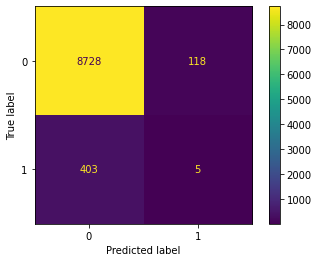

In [ ]:
print_classification_report_n_mconfusion(y_predict, y_test)

## Weighted Class Linear SVM
Viene aumentato il peso della classe 1 (aumentando il focus sulle istanze di tale classe -> ovvero gli abbandoni)

In [ ]:
filename = 'weighted_class_linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = load_model(filename)
else:
  _svm = svm.SVC(kernel='linear', class_weight={1: 10})
  _svm.fit(x_train, y_train)
  save_model(_svm, filename)

y_predict = _svm.predict(x_test)

### Metriche di performance

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8861
           1       0.03      0.04      0.03       393

    accuracy                           0.92      9254
   macro avg       0.50      0.50      0.50      9254
weighted avg       0.92      0.92      0.92      9254



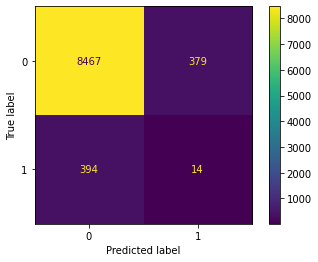

In [ ]:
print_classification_report_n_mconfusion(y_predict, y_test)

## Weighted Samples Linear SVM
Vengono pesate maggiormente le singole istanze (vanno quindi prima trovate)

In [ ]:
sample_weight = np.ones(len(x_train))
for id in dropout_ids:
  try:
    if(x_train.iloc[id - 1] is not None):
      sample_weight[id - 1] = 50
  except:
    print("Id: " + str(id) + " not in train test")
    

weighted_samples_linear_svm_filename = 'weighted_samples_linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = load_model(weighted_samples_linear_svm_filename)
else:
  _svm = svm.SVC(kernel='linear')
  _svm.fit(x_train, y_train, sample_weight=sample_weight)
  save_model(_svm, weighted_samples_linear_svm_filename)

y_predict = _svm.predict(x_test)

Id: 52447 not in train test
Id: 52514 not in train test
Id: 52519 not in train test
Id: 52560 not in train test
Id: 52573 not in train test
Id: 52590 not in train test
Id: 52600 not in train test
Id: 52605 not in train test
Id: 52622 not in train test
Id: 52660 not in train test
Id: 52691 not in train test
Id: 52745 not in train test
Id: 52760 not in train test
Id: 52773 not in train test
Id: 52811 not in train test
Id: 52828 not in train test
Id: 52844 not in train test
Id: 52858 not in train test
Id: 52862 not in train test
Id: 52864 not in train test
Id: 52907 not in train test
Id: 52932 not in train test
Id: 52934 not in train test
Id: 52945 not in train test
Id: 52964 not in train test
Id: 52999 not in train test
Id: 53061 not in train test
Id: 53071 not in train test
Id: 53076 not in train test
Id: 53090 not in train test
Id: 53152 not in train test
Id: 53196 not in train test
Id: 53199 not in train test
Id: 53214 not in train test
Id: 53247 not in train test
Id: 53260 not in tra

### Metriche di performance

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      9117
           1       0.01      0.04      0.02       137

    accuracy                           0.94      9254
   macro avg       0.50      0.50      0.50      9254
weighted avg       0.97      0.94      0.96      9254



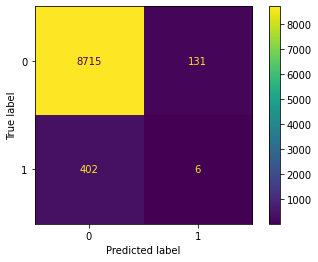

In [ ]:
print_classification_report_n_mconfusion(y_predict, y_test)

# ANN Basic autoencoder

## Costruzione modello

Per la realizzazione del modello si è scelto di utilizzare la libreria [Keras](https://keras.io/api/), essendo sviluppata logicamente sopra Tensorflow, ovvero Keras utlizza Tensorflow come back-end engine, è di facile utilizzo così da non rendere la curva di apprendimento del framework esageratamente alta ed infine essendo il framework numero uno per quanto riguarda l'ambito machine learning presenta una vasta comunity e un'API ben documentata.

Keras espone un'API di alto livello con cui è possibile costruire reti neurali arbitrariamente complesse senza dover conoscere a fondo i meccanismi di funzionamento e le strutture dati adoperate da Tensorflow.

Il modello è composto da 2 hidden layers composti da 1024 neuroni. Il primo layer ha come funzione di attivazione la funzione ReLU mentre il secondo la funzione sigmoid (sigmoide).

Attraverso la funzione Sequential() si crea un modello in grado di raggruppare una sequenza lineare di layer.
Con il metodo add() si possono aggiungere diversi tipi di layer, in questo caso tutti i layer sono di tipo *Dense* ovvero fortemente connessi con il layer inferiore e superiore.



In [ ]:
input_n_output_dim = x_train.shape[1] #312

# nr. di neuroni nell'encoding layer
encoding_dim = 64
encoding_dim_1 = 128
encoding_dim_2 = 256

# modern way of declaring the model
autoencoder = Sequential()
autoencoder.add(Input(shape=(input_n_output_dim,)))
autoencoder.add(Dense(encoding_dim_2, activation='relu'))
autoencoder.add(Dense(encoding_dim_1, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))
#autoencoder.add(Dropout(0.10))
autoencoder.add(Dense(encoding_dim_1, activation='relu'))
#autoencoder.add(Dropout(0.15))
autoencoder.add(Dense(encoding_dim_2, activation='relu'))
#autoencoder.add(Dropout(0.10))
autoencoder.add(Dense(input_n_output_dim, activation='relu'))

autoencoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 256)               80128     
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 dense_69 (Dense)            (None, 128)               8320      
                                                                 
 dense_70 (Dense)            (None, 256)               33024     
                                                                 
 dense_71 (Dense)            (None, 312)               80184     
                                                                 
Total params: 242,808
Trainable params: 242,808
Non-t

## Addestramento

Il modello viene addestrato usando come funzione di costo la *mse* (mean squared error) e come ottimizzatore si è scelto di utilizzare Adam (Adaptive moment estimation).
Il numero delle epoche è 30 e come batch size si è scelto 256

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0080)
autoencoder.compile(optimizer=opt, loss='mse') #(adam, RMSprop, Adamax) - mse

Il primo parametro rappresenta l'input del modello mentre il secondo il target, specificando i primi due paramentri (x e y) uguali, si forza il modello a cercare di ricostruire i valori in ingresso.
Viene inoltre specificato un validation_split dell'1% così da poter monitorare la validation loss durante la fase di training

Epoch 1/150
52/52 [==============================] - 5s 71ms/step - loss: 139775.5938 - val_loss: 4915.1016
Epoch 2/150
52/52 [==============================] - 3s 64ms/step - loss: 1680.0118 - val_loss: 2.3881
Epoch 3/150
52/52 [==============================] - 3s 65ms/step - loss: 4.3059 - val_loss: 0.2349
Epoch 4/150
52/52 [==============================] - 2s 40ms/step - loss: 104.5313 - val_loss: 19.1599
Epoch 5/150
52/52 [==============================] - 2s 39ms/step - loss: 14.1482 - val_loss: 155.7565
Epoch 6/150
52/52 [==============================] - 2s 39ms/step - loss: 35.8334 - val_loss: 0.0753
Epoch 7/150
52/52 [==============================] - 2s 39ms/step - loss: 132.3894 - val_loss: 157.6544
Epoch 8/150
52/52 [==============================] - 2s 38ms/step - loss: 22.4705 - val_loss: 0.1425
Epoch 9/150
52/52 [==============================] - 2s 39ms/step - loss: 0.4023 - val_loss: 0.1002
Epoch 10/150
52/52 [==============================] - 2s 39ms/step - loss: 0.

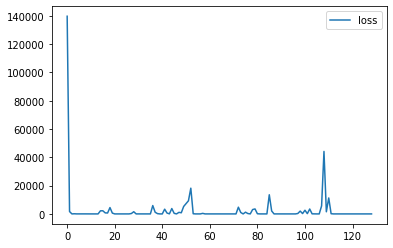

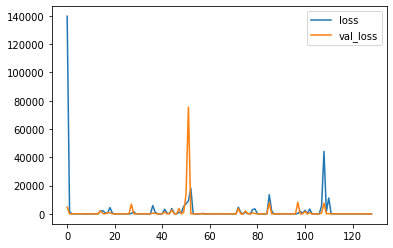

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

autoencoder.fit(
        x_train,
        x_train,
        epochs = 150,
        batch_size = 1024,
        validation_data = (x_test, x_test),
        callbacks=[early_stop],
)

losses = pd.DataFrame(autoencoder.history.history)
losses[['loss']].plot()
losses[['loss','val_loss']].plot()

## Validazione modello

In [ ]:
prediction_errors = []

reconstructed = autoencoder.predict(x_test)

mse = np.mean(np.power(x_test - reconstructed, 2), axis=1)
z_scores = Z_Score(mse)
print(str(z_scores))

3515     1.452027
31577   -0.731216
102     -0.049404
38920   -0.692198
20190   -0.447107
           ...   
56127    0.986293
4563     1.668027
4108    -0.084291
9099     3.639377
6218     0.547409
Length: 9254, dtype: float64


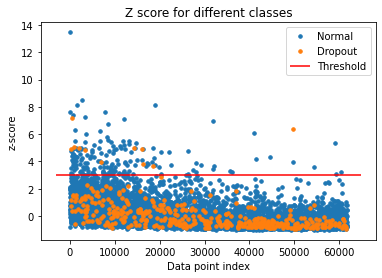

In [ ]:
threshold_fixed = 3
error_df_test = pd.DataFrame({'Z_score': z_scores,
                        'True_class': y_test})
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Z_score, marker='o', ms=3.5, linestyle='',
            label= "Dropout" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Z score for different classes")
plt.ylabel("z-score")
plt.xlabel("Data point index")
plt.show();

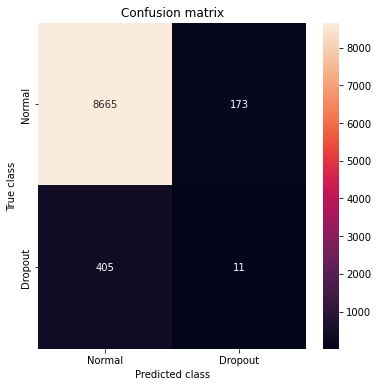

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test.Z_score.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=["Normal","Dropout"], yticklabels=["Normal", "Dropout"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()